# Detailed Evaluation

This notebook shows how to produce some tables and plots for analysing results. This is meant as a starting point, because eah game will require a custom evaluation depending on its metrics and experiments.

This notebook uses the output files of evaluation/bencheval.py. Run that first.

In [757]:
import sys
# sys.path.append('..')

from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import clemgame.metrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [758]:
RAW_PATH = Path('results/raw.csv')
# RAW_PATH = 'results/raw.csv'
# RAW_PATH = Path('\\results\\raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Let's inspect the contents of ```data```:

In [759]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_5,Played,0.0
36732,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_6,Played,0.0
36733,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_7,Played,0.0
36734,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_8,Played,0.0


In [760]:
model_name_dict = {
    'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B-Instruct"
}

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_hard': "basic-hard",
    '3_home_deliver_three_planning_hard': "planning-hard"
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
}

If we want to evaluate a single game and the results directory contained more games, we can filter the game column:

In [761]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,Played,0.0
36732,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,Played,0.0
36733,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,Played,0.0
36734,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,Played,0.0


Failure metrics:

In [762]:
failures_by_phase_df = game_df.query(
    'metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,action_resolution_fail,16.0
45,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,action_parsing_fail,0.0
46,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,action_resolution_fail,18.0
85,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
35726,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,action_resolution_fail,0.0
35765,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,action_parsing_fail,0.0
35766,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,action_resolution_fail,0.0
35805,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_9,action_parsing_fail,0.0


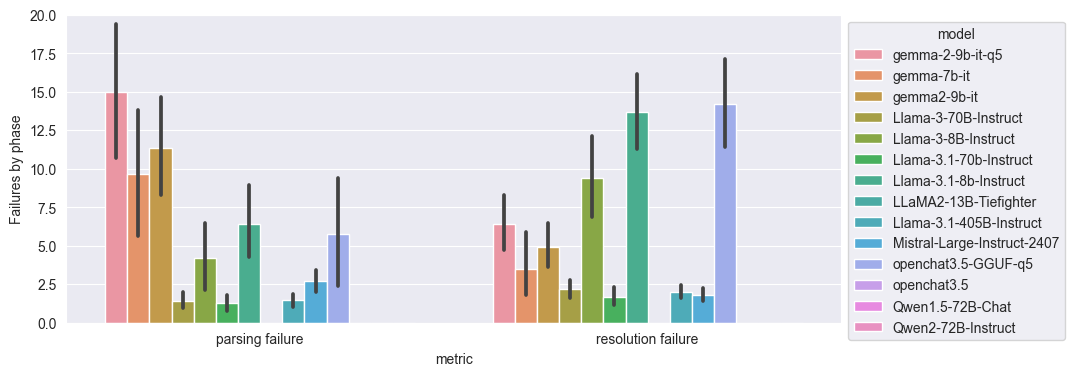

In [763]:
# change the figure size according to your needs
fig, ax = plt.subplots(figsize=(10, 4))

# choose what goes in each axis and legend according to your needs
# you can also e.g. swap y and hue, to get games in the legend and models in the axis
g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
# customize plot details according to your needs
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 20)
plt.ylabel("Failures by phase")

plt.show()

In [764]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
LLaMA2-13B-Tiefighter,0.0
Llama-3-70B-Instruct,1167.0
Llama-3-8B-Instruct,1635.0
Llama-3.1-405B-Instruct,1342.0
Llama-3.1-70b-Instruct,1236.0
Llama-3.1-8b-Instruct,2407.0
Mistral-Large-Instruct-2407,1087.0
Qwen1.5-72B-Chat,0.0
Qwen2-72B-Instruct,0.0


In [765]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model                       metric                   
LLaMA2-13B-Tiefighter       parsing failure       0.0
                            resolution failure    0.0
Llama-3-70B-Instruct        parsing failure      92.0
                            resolution failure  139.0
Llama-3-8B-Instruct         parsing failure     270.0
                            resolution failure  602.0
Llama-3.1-405B-Instruct     parsing failure      93.0
                            resolution failure  129.0
Llama-3.1-70b-Instruct      parsing failure      81.0
                            resolution failure  106.0
Llama-3.1-8b-Instruct       parsing failure     412.0
                            resolution failure  874.0
Mistral-Large-Instruct-2407 parsing failure     172.0
                            resolution failure  117.0
Qwen1.5-72B-Chat            parsing failure       0.0
                            resolution failure    0.0
Qwen2-72B-Instruct          parsing failure       0.0
                            resolution failure    0.0
gemma-2-9b-it-q5            parsing failure     960.0
                            resolution failure  410.0
gemma-7b-it                 parsing failure     619.0
                            resolution failure  225.0
gemma2-9b-it                parsing failure     726.0
                            resolution failure  316.0
openchat3.5                 parsing failure       0.0
                            resolution failure    0.0
openchat3.5-GGUF-q5         parsing failure     370.0
                            resolution failure  911.0

In [766]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model                       metric                      
LLaMA2-13B-Tiefighter       parsing failure          NaN
                            resolution failure       NaN
Llama-3-70B-Instruct        parsing failure     0.078835
                            resolution failure  0.119109
Llama-3-8B-Instruct         parsing failure     0.165138
                            resolution failure  0.368196
Llama-3.1-405B-Instruct     parsing failure     0.069300
                            resolution failure  0.096125
Llama-3.1-70b-Instruct      parsing failure     0.065534
                            resolution failure  0.085761
Llama-3.1-8b-Instruct       parsing failure     0.171167
                            resolution failure  0.363108
Mistral-Large-Instruct-2407 parsing failure     0.158234
                            resolution failure  0.107636
Qwen1.5-72B-Chat            parsing failure          NaN
                            resolution failure       NaN
Qwen2-72B-Instruct          parsing failure          NaN
                            resolution failure       NaN
gemma-2-9b-it-q5            parsing failure     0.399833
                            resolution failure  0.170762
gemma-7b-it                 parsing failure     0.642783
                            resolution failure  0.233645
gemma2-9b-it                parsing failure     0.359762
                            resolution failure  0.156591
openchat3.5                 parsing failure          NaN
                            resolution failure       NaN
openchat3.5-GGUF-q5         parsing failure     0.163283
                            resolution failure  0.402030

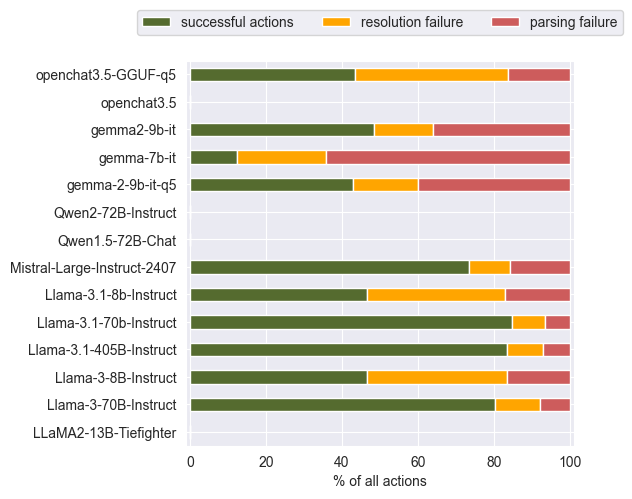

In [767]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
# order = clem_df.sort_values(by='-, clemscore').index
# percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

In [768]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts

value     ratio
model                 metric                                
LLaMA2-13B-Tiefighter malformed command        0.0       NaN
                      out of grammar           0.0       NaN
                      undefined action type    0.0       NaN
                      undefined action verb    0.0       NaN
                      undefined antecedent     0.0       NaN
...                                            ...       ...
openchat3.5-GGUF-q5   out of grammar          57.0  0.025154
                      undefined action type    0.0  0.000000
                      undefined action verb  216.0  0.095322
                      undefined antecedent     0.0  0.000000
                      undefined noun          46.0  0.020300

[84 rows x 2 columns]

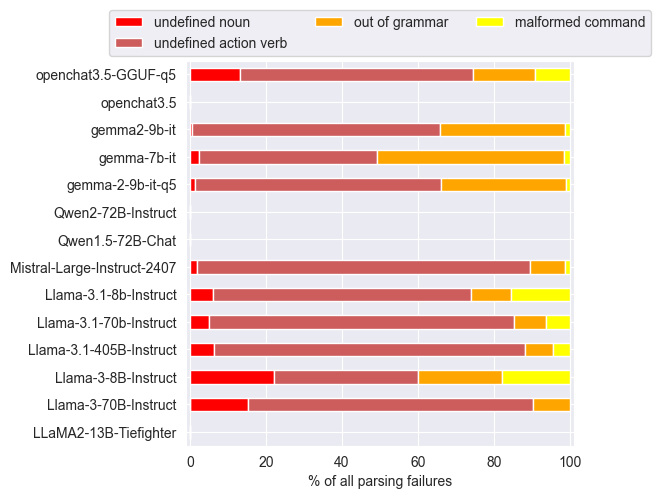

In [769]:
STACK_COLORS = ['red', 'indianred', 'orange', 'yellow']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
# order = clem_df.sort_values(by='-, clemscore').index
# percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

In [770]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model                 metric                                      
LLaMA2-13B-Tiefighter first entity is room           0.0       NaN
                      going to non-adjacent room     0.0       NaN
                      going to non-existent room     0.0       NaN
                      interacting with other room    0.0       NaN
                      manipulating room              0.0       NaN
...                                                  ...       ...
openchat3.5-GGUF-q5   going to non-adjacent room   282.0  0.124448
                      going to non-existent room     9.0  0.003972
                      interacting with other room   15.0  0.006620
                      manipulating room              0.0  0.000000
                      second entity is room          0.0  0.000000

[84 rows x 2 columns]

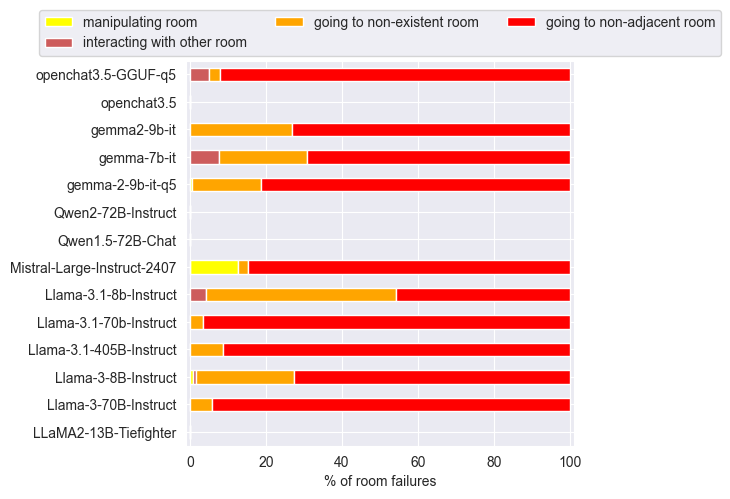

In [771]:
STACK_COLORS = ['yellow', 'orange', 'indianred', 'yellow', 'orange', 'red']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
# order = clem_df.sort_values(by='-, clemscore').index
# percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

In [801]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "pre_state_mismatch"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model                       metric                                      
LLaMA2-13B-Tiefighter       entity already in inventory    0.0       NaN
                            entity not accessible          0.0       NaN
                            main condition not fact        0.0       NaN
Llama-3-70B-Instruct        entity already in inventory    0.0  0.000000
                            entity not accessible         69.0  0.059126
                            main condition not fact        2.0  0.001714
Llama-3-8B-Instruct         entity already in inventory    5.0  0.003058
                            entity not accessible        274.0  0.167584
                            main condition not fact      195.0  0.119266
Llama-3.1-405B-Instruct     entity already in inventory    0.0  0.000000
                            entity not accessible         48.0  0.035768
                            main condition not fact        0.0  0.000000
Llama-3.1-70b-Instruct      entity already in inventory    0.0  0.000000
                            entity not accessible         46.0  0.037217
                            main condition not fact        2.0  0.001618
Llama-3.1-8b-Instruct       entity already in inventory    6.0  0.002493
                            entity not accessible        430.0  0.178646
                            main condition not fact      171.0  0.071043
Mistral-Large-Instruct-2407 entity already in inventory    0.0  0.000000
                            entity not accessible         46.0  0.042318
                            main condition not fact        0.0  0.000000
Qwen1.5-72B-Chat            entity already in inventory    0.0       NaN
                            entity not accessible          0.0       NaN
                            main condition not fact        0.0       NaN
Qwen2-72B-Instruct          entity already in inventory    0.0       NaN
                            entity not accessible          0.0       NaN
                            main condition not fact        0.0       NaN
gemma-2-9b-it-q5            entity already in inventory    1.0  0.000416
                            entity not accessible        233.0  0.097043
                            main condition not fact       15.0  0.006247
gemma-7b-it                 entity already in inventory    0.0  0.000000
                            entity not accessible        212.0  0.220145
                            main condition not fact        1.0  0.001038
gemma2-9b-it                entity already in inventory    1.0  0.000496
                            entity not accessible        154.0  0.076313
                            main condition not fact       20.0  0.009911
openchat3.5                 entity already in inventory    0.0       NaN
                            entity not accessible          0.0       NaN
                            main condition not fact        0.0       NaN
openchat3.5-GGUF-q5         entity already in inventory    5.0  0.002207
                            entity not accessible        553.0  0.244042
                            main condition not fact       26.0  0.011474

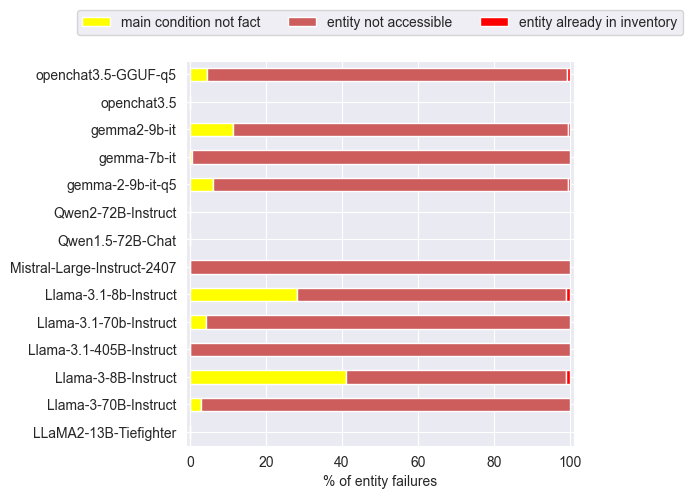

In [773]:
STACK_COLORS = ['yellow', 'indianred', 'red']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "pre_state_mismatch"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
# order = clem_df.sort_values(by='-, clemscore').index
# percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

## Overview tables

Get dispersion metrics over all episodes. Note that we use groupby, which will ignore NaN values, according to the documentation!

In [774]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean   
game          model                 metric                              
adventuregame LLaMA2-13B-Tiefighter Aborted                   1.00000  \
                                    Lose                      0.00000   
                                    Main Score                0.00000   
                                    Parsed Request Count      0.00000   
                                    Played                    0.00000   
...                                                               ...   
              openchat3.5-GGUF-q5   turns_over_par           10.00000   
                                    undefined_action          0.00000   
                                    undefined_action_verb     3.37500   
                                    undefined_argument_type   0.00000   
                                    undefined_repr_str        0.71875   

                                                                   std   
game          model                 metric                               
adventuregame LLaMA2-13B-Tiefighter Aborted                   0.000000  \
                                    Lose                      0.000000   
                                    Main Score                0.000000   
                                    Parsed Request Count      0.000000   
                                    Played                    0.000000   
...                                                                ...   
              openchat3.5-GGUF-q5   turns_over_par           11.313708   
                                    undefined_action          0.000000   
                                    undefined_action_verb    11.335434   
                                    undefined_argument_type   0.000000   
                                    undefined_repr_str        3.538759   

                                                                    var   
game          model                 metric                                
adventuregame LLaMA2-13B-Tiefighter Aborted                    0.000000  \
                                    Lose                       0.000000   
                                    Main Score                 0.000000   
                                    Parsed Request Count       0.000000   
                                    Played                     0.000000   
...                                                                 ...   
              openchat3.5-GGUF-q5   turns_over_par           128.000000   
                                    undefined_action           0.000000   
                                    undefined_action_verb    128.492063   
                                    undefined_argument_type    0.000000   
                                    undefined_repr_str        12.522817   

                                                             median   max   
game          model                 metric                                  
adventuregame LLaMA2-13B-Tiefighter Aborted                     1.0   1.0  \
                                    Lose                        0.0   0.0   
                                    Main Score                  0.0   0.0   
                                    Parsed Request Count        0.0   0.0   
                                    Played                      0.0   0.0   
...                                                             ...   ...   
              openchat3.5-GGUF-q5   turns_over_par             10.0  18.0   
                                    undefined_action            0.0   0.0   
                                    undefined_action_verb       0.0  48.0   
                                    undefined_argument_type     0.0   0.0   
                                    undefined_repr_str          0.0  25.0   

                                                             min      skew  
game          model                 metric                                  
adventuregame LLaMA2

In [775]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
# failures_by_phase_df = failures_by_phase_df.drop(columns=["game"])
failure_stats_by_phase_df

mean   
game          model                       metric                              
adventuregame LLaMA2-13B-Tiefighter       action_parsing_fail      0.000000  \
                                          action_resolution_fail   0.000000   
              Llama-3-70B-Instruct        action_parsing_fail      1.437500   
                                          action_resolution_fail   2.171875   
              Llama-3-8B-Instruct         action_parsing_fail      4.218750   
                                          action_resolution_fail   9.406250   
              Llama-3.1-405B-Instruct     action_parsing_fail      1.453125   
                                          action_resolution_fail   2.015625   
              Llama-3.1-70b-Instruct      action_parsing_fail      1.265625   
                                          action_resolution_fail   1.656250   
              Llama-3.1-8b-Instruct       action_parsing_fail      6.437500   
                                          action_resolution_fail  13.656250   
              Mistral-Large-Instruct-2407 action_parsing_fail      2.687500   
                                          action_resolution_fail   1.828125   
              Qwen1.5-72B-Chat            action_parsing_fail      0.000000   
                                          action_resolution_fail   0.000000   
              Qwen2-72B-Instruct          action_parsing_fail      0.000000   
                                          action_resolution_fail   0.000000   
              gemma-2-9b-it-q5            action_parsing_fail     15.000000   
                                          action_resolution_fail   6.406250   
              gemma-7b-it                 action_parsing_fail      9.671875   
                                          action_resolution_fail   3.515625   
              gemma2-9b-it                action_parsing_fail     11.343750   
                                          action_resolution_fail   4.937500   
              openchat3.5                 action_parsing_fail      0.000000   
                                          action_resolution_fail   0.000000   
              openchat3.5-GGUF-q5         action_parsing_fail      5.781250   
                                          action_resolution_fail  14.234375   

                                                                        std   
game          model                       metric                              
adventuregame LLaMA2-13B-Tiefighter       action_parsing_fail      0.000000  \
                                          action_resolution_fail   0.000000   
              Llama-3-70B-Instruct        action_parsing_fail      2.280873   
                                          action_resolution_fail   2.285598   
              Llama-3-8B-Instruct         action_parsing_fail      9.585817   
                                          action_resolution_fail  11.043520   
              Llama-3.1-405B-Instruct     action_parsing_fail      1.699016   
                                          action_resolution_fail   1.821322   
              Llama-3.1-70b-Instruct      action_parsing_fail      2.139887   
                                          action_resolution_fail   2.358495   
              Llama-3.1-8b-Instruct       action_parsing_fail      9.894483   
                                          action_resolution_fail  10.220146   
              Mistral-Large-Instruct-2407 action_parsing_fail      2.937848   
                                          action_resolution_fail   1.821866   
              Qwen1.5-72B-Chat            action_parsing_fail      0.000000   
                                          action_resolution_fail   0.000000   
              Qwen2-72B-Instruct          action_parsing_fail      0.000000   
                                          action_resolution_fail   0.000000   
              gemma-2-9b-it-q5            action_parsing_fail     17.457431   
                                         

Break results down by experiment:

In [776]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean   
game          model                 experiment    metric                            
adventuregame LLaMA2-13B-Tiefighter basic-easy    Aborted                  1.0000  \
                                                  Lose                     0.0000   
                                                  Main Score               0.0000   
                                                  Parsed Request Count     0.0000   
                                                  Played                   0.0000   
...                                                                           ...   
              openchat3.5-GGUF-q5   planning-hard turns_over_par              NaN   
                                                  undefined_action         0.0000   
                                                  undefined_action_verb    0.9375   
                                                  undefined_argument_type  0.0000   
                                                  undefined_repr_str       2.6875   

                                                                                std   
game          model                 experiment    metric                              
adventuregame LLaMA2-13B-Tiefighter basic-easy    Aborted                  0.000000  \
                                                  Lose                     0.000000   
                                                  Main Score               0.000000   
                                                  Parsed Request Count     0.000000   
                                                  Played                   0.000000   
...                                                                             ...   
              openchat3.5-GGUF-q5   planning-hard turns_over_par                NaN   
                                                  undefined_action         0.000000   
                                                  undefined_action_verb    2.462214   
                                                  undefined_argument_type  0.000000   
                                                  undefined_repr_str       6.848053   

                                                                                 var   
game          model                 experiment    metric                               
adventuregame LLaMA2-13B-Tiefighter basic-easy    Aborted                   0.000000  \
                                                  Lose                      0.000000   
                                                  Main Score                0.000000   
                                                  Parsed Request Count      0.000000   
                                                  Played                    0.000000   
...                                                                              ...   
              openchat3.5-GGUF-q5   planning-hard turns_over_par                 NaN   
                                                  undefined_action          0.000000   
                                                  undefined_action_verb     6.062500   
                                                  undefined_argument_type   0.000000   
                                                  undefined_repr_str       46.895833   

                                                                           median   
game          model                 experiment    metric                            
adventuregame LLaMA2-13B-Tiefighter basic-easy    Aborted                     1.0  \
                                                  Lose                        0.0   
                                                  Main Score                  0.0   
                                                  Parsed Request Count        0.0   
                                                  Played                      0.0   
...                                                                           ...   
              

To save the table, call ```to_csv```, ```to_html``` and/or ```to_latex``` (there are also other formats and customization options, check the pandas docs):

In [777]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [820]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Planning variant:

In [778]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard"]')
plan_df

,game,model,experiment,episode,metric,value
640,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Violated Request Count,1.000
641,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Parsed Request Count,7.000
642,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Request Count,8.000
643,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Request Success Ratio,0.875
644,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,hallucination_count,0.000
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,Played,0.000
36732,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,Played,0.000
36733,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,Played,0.000
36734,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,Played,0.000


Hallucinations:

In [779]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
44,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,hallucination_count,0.0
84,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_10,hallucination_count,0.0
124,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_11,hallucination_count,0.0
164,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_12,hallucination_count,0.0
...,...,...,...,...,...,...
35644,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,hallucination_count,0.0
35684,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,hallucination_count,0.0
35724,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,hallucination_count,0.0
35764,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,hallucination_count,0.0


In [780]:
# llama3_1_70b_hallu = hallucination_df.query('model == "llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0" and value == 1')
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value
13004,adventuregame,Llama-3.1-70b-Instruct,basic-easy,episode_13,hallucination_count,1.0
13524,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_10,hallucination_count,1.0
13564,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_11,hallucination_count,1.0
13604,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_12,hallucination_count,1.0
13644,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_13,hallucination_count,1.0
13684,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_14,hallucination_count,1.0
13724,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_15,hallucination_count,1.0
14124,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_1,hallucination_count,1.0
14164,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_10,hallucination_count,1.0
14244,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_12,hallucination_count,1.0


In [804]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:14, [4]]
hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Ratio
model,,
LLaMA2-13B-Tiefighter,0.0,0.000000
Llama-3-70B-Instruct,19.0,0.296875
Llama-3-8B-Instruct,4.0,0.062500
Llama-3.1-405B-Instruct,9.0,0.140625
Llama-3.1-70b-Instruct,14.0,0.218750
Llama-3.1-8b-Instruct,0.0,0.000000
Mistral-Large-Instruct-2407,4.0,0.062500
Qwen1.5-72B-Chat,0.0,0.000000
Qwen2-72B-Instruct,1.0,0.015625


In [782]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [783]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Ratio", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [784]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
LLaMA2-13B-Tiefighter,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
Llama-3-70B-Instruct,0.296875,0.460493,0.212054,0.0,1.0,0.0,0.910665
Llama-3-8B-Instruct,0.062500,0.243975,0.059524,0.0,1.0,0.0,3.702124
Llama-3.1-405B-Instruct,0.140625,0.350382,0.122768,0.0,1.0,0.0,2.117502
Llama-3.1-70b-Instruct,0.218750,0.416667,0.173611,0.0,1.0,0.0,1.393548
Llama-3.1-8b-Instruct,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
Mistral-Large-Instruct-2407,0.062500,0.243975,0.059524,0.0,1.0,0.0,3.702124
Qwen1.5-72B-Chat,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
Qwen2-72B-Instruct,0.015625,0.125000,0.015625,0.0,1.0,0.0,8.000000


## Basic Plots

Plots can of course be created with ```matplotlib``` directly, but ```seaborn``` makes it very easy to work with pandas dataframes. Let's create a barplot with an overview by model and experiment:

In [814]:
def metric_bar_plot(source_df, metric, max=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    
    # change the figure size according to your needs
    fig, ax = plt.subplots(figsize=(10, 4))

    # choose what goes in each axis and legend according to your needs
    # you can also e.g. swap y and hue, to get games in the legend and models in the axis
    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    # customize plot details according to your needs
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max)
    plt.ylabel(metric)

    plt.show()

In [815]:
metric_df = game_df[game_df.metric == "Main Score"].sort_values('experiment')
metric_df

,game,model,experiment,episode,metric,value
32,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Main Score,0.000000
13432,adventuregame,Llama-3.1-70b-Instruct,basic-easy,episode_9,Main Score,100.000000
13392,adventuregame,Llama-3.1-70b-Instruct,basic-easy,episode_8,Main Score,100.000000
13352,adventuregame,Llama-3.1-70b-Instruct,basic-easy,episode_7,Main Score,100.000000
13312,adventuregame,Llama-3.1-70b-Instruct,basic-easy,episode_6,Main Score,100.000000
...,...,...,...,...,...,...
19912,adventuregame,LLaMA2-13B-Tiefighter,planning-hard,episode_1,Main Score,0.000000
19872,adventuregame,LLaMA2-13B-Tiefighter,planning-hard,episode_0,Main Score,0.000000
35792,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,Main Score,0.000000
15032,adventuregame,Llama-3.1-70b-Instruct,planning-hard,episode_15,Main Score,33.333333


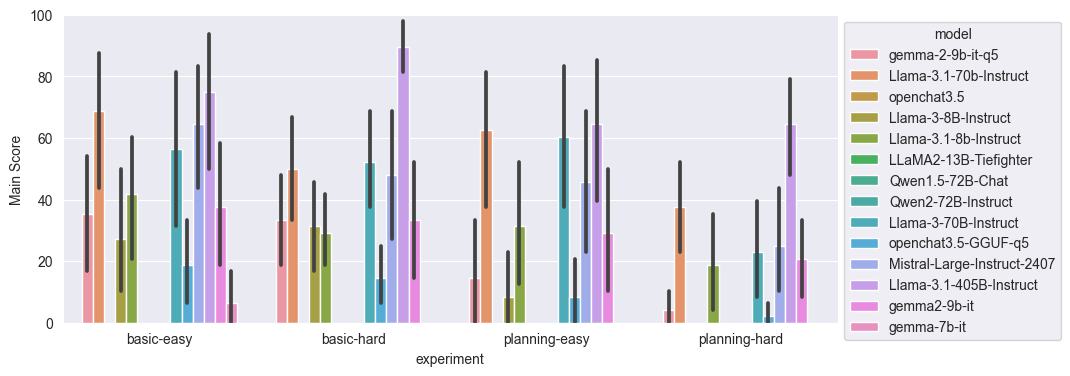

In [816]:
metric_bar_plot(game_df, "Main Score", max=100)

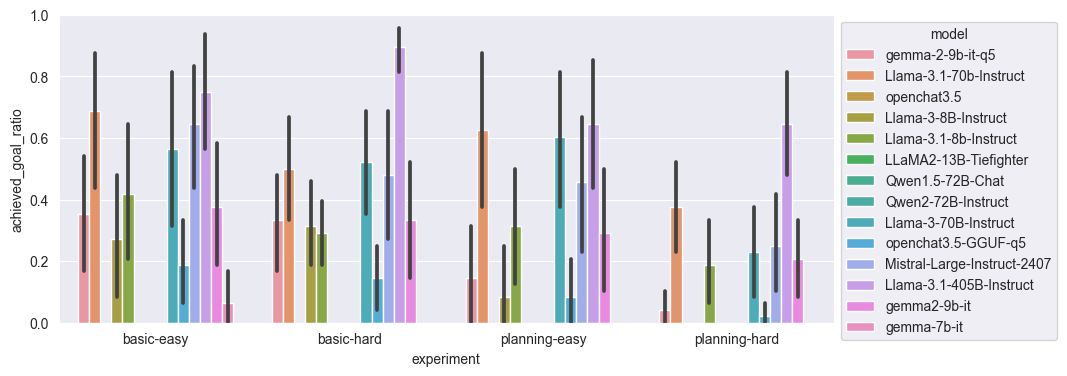

In [817]:
metric_bar_plot(game_df, "achieved_goal_ratio")

Only considering finished instances:

D:\clembench\venv_llamacpp\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
D:\clembench\venv_llamacpp\Lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


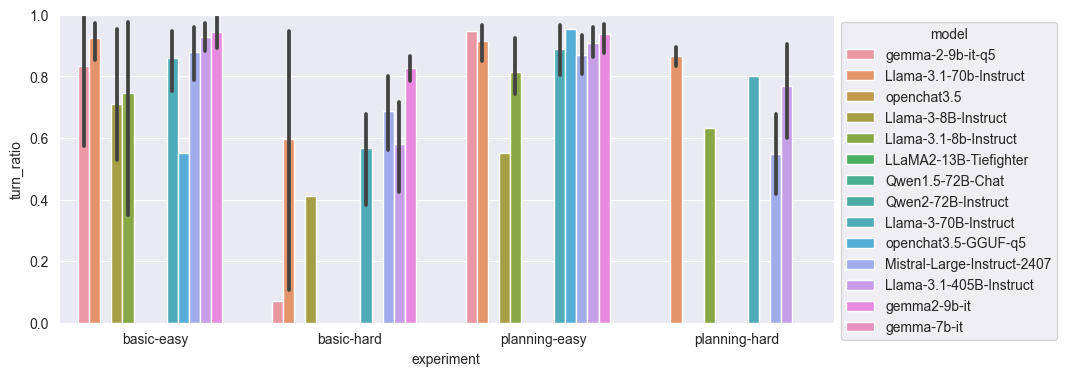

In [818]:
metric_bar_plot(game_df, "turn_ratio")

D:\clembench\venv_llamacpp\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
D:\clembench\venv_llamacpp\Lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


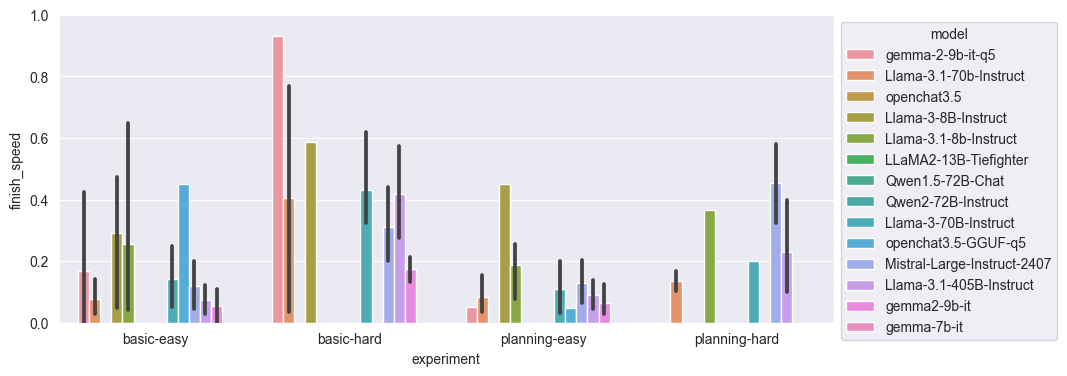

In [819]:
metric_bar_plot(game_df, "finish_speed")

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_1076\3867107116.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('model')


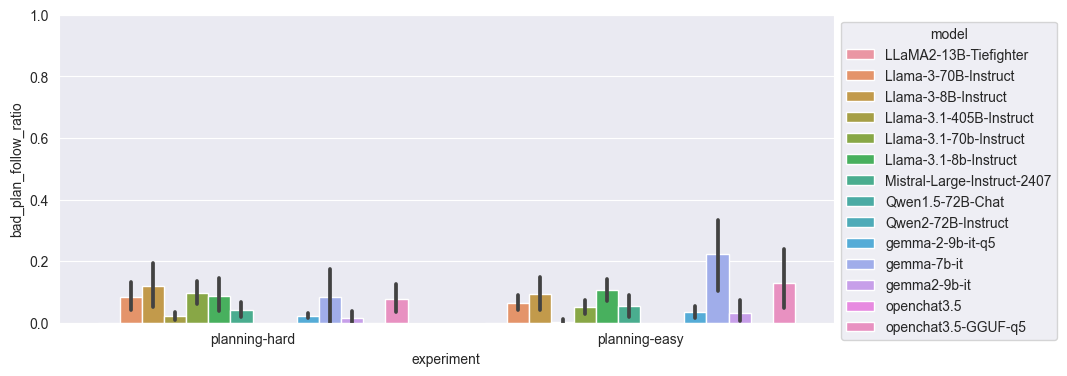

In [810]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_1076\3867107116.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('model')


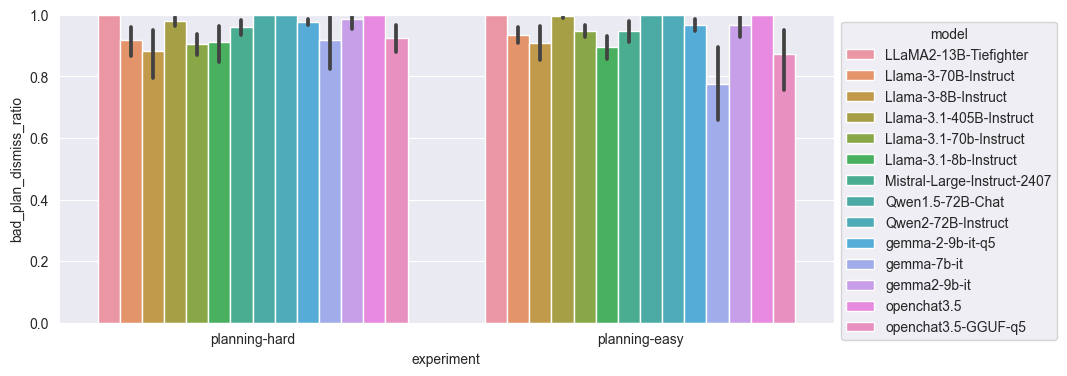

In [811]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_1076\3867107116.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('model')


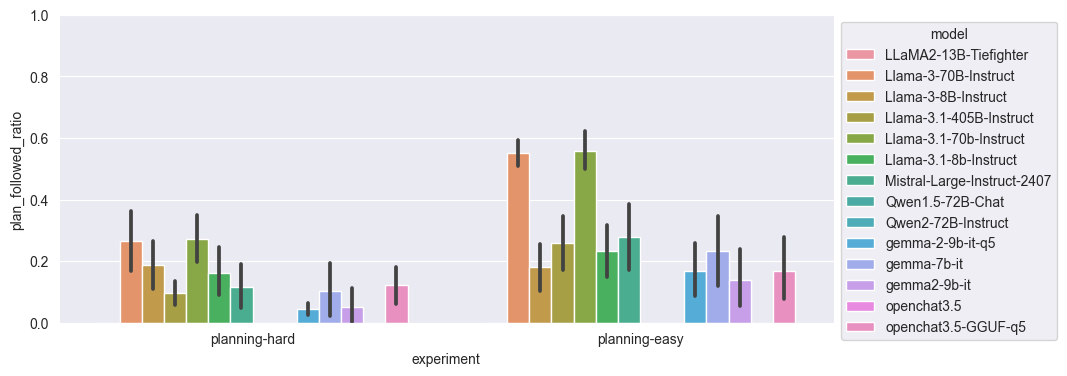

In [812]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_1076\3867107116.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('model')


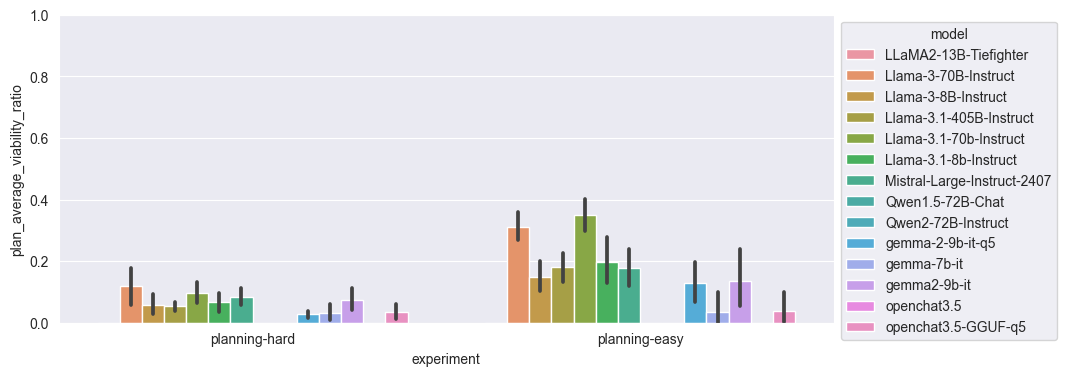

In [813]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")

## Benchmark plots

Reproducing Figure 10 in the paper. As more models or games are added, sizes must be adjusted accordingly:

In [795]:
# read the clem scores
# RESULTS_PATH = Path('../results/results.csv')
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

In [796]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
LLaMA2-13B-Tiefighter,0.00,0.00,0.00,0.00,0.00,0.00
Llama-3-70B-Instruct,17.22,35.94,47.92,44.00,35.94,47.92
Llama-3-8B-Instruct,7.29,43.75,16.67,31.43,43.75,16.67
Llama-3.1-405B-Instruct,45.90,62.50,73.44,38.11,62.50,73.44
Mistral-Large-Instruct-2407,15.04,32.81,45.83,44.25,32.81,45.83
Qwen1.5-72B-Chat,0.00,0.00,0.00,0.00,0.00,0.00
Qwen2-72B-Instruct,0.00,0.00,0.00,0.00,0.00,0.00
gemma-2-9b-it-q5,12.64,57.81,21.87,33.18,57.81,21.87
gemma-7b-it,0.34,21.88,1.56,9.26,21.88,1.56
gemma2-9b-it,13.22,43.75,30.21,38.36,43.75,30.21


In [797]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score"])
overview_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)"
LLaMA2-13B-Tiefighter,0.00,0.00,0.00,0.00
Llama-3-70B-Instruct,17.22,35.94,47.92,44.00
Llama-3-8B-Instruct,7.29,43.75,16.67,31.43
Llama-3.1-405B-Instruct,45.90,62.50,73.44,38.11
Mistral-Large-Instruct-2407,15.04,32.81,45.83,44.25
Qwen1.5-72B-Chat,0.00,0.00,0.00,0.00
Qwen2-72B-Instruct,0.00,0.00,0.00,0.00
gemma-2-9b-it-q5,12.64,57.81,21.87,33.18
gemma-7b-it,0.34,21.88,1.56,9.26
gemma2-9b-it,13.22,43.75,30.21,38.36


In [798]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

Horizontal bar plot with player, aborted, lost:

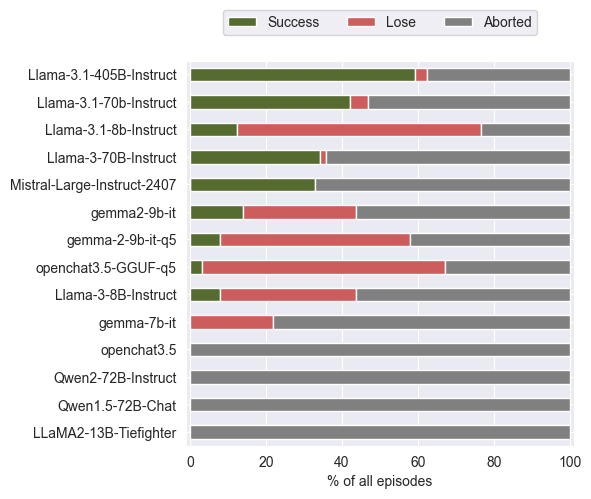

In [799]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]
df_aux = df_aux.replace(model_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with the sorted clemscores (they were not sorted in the paper):

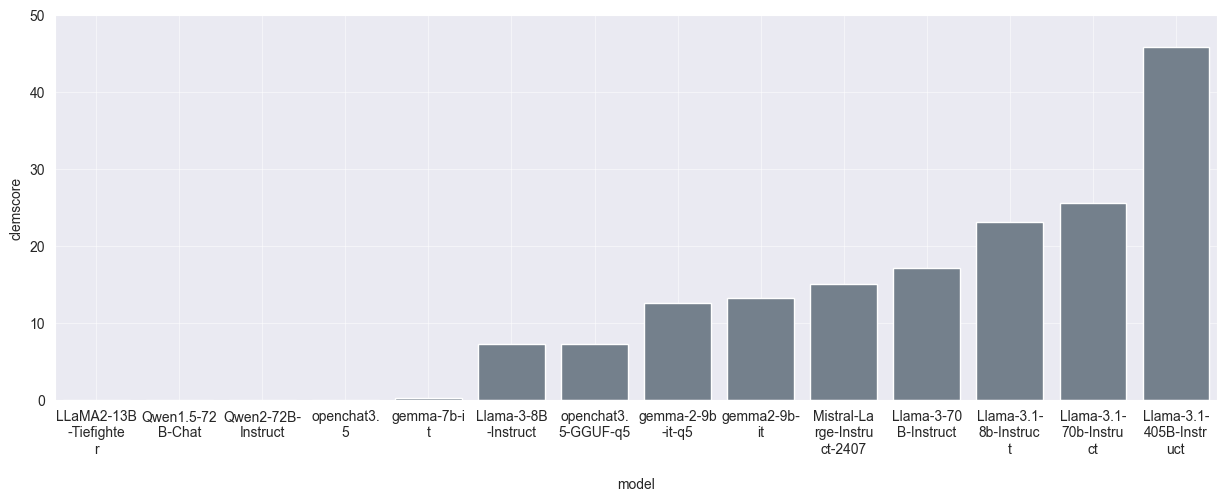

In [800]:
# clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model')
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# below is a hack to make the current names fit the plot
# ideally a dictionary with short names should be used as in the original implementation for the paper
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 50)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()